# <font color='mediumpurple'>Diagnóstico por Imagem</font>

#### Informática Biomédica
#### Universidade Federal de Ciências da Saúde de Porto Alegre - UFCSPA  

Bianca Siega Bernardi

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2
import os
import shutil
import itertools
import imutils

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import plotly.graph_objects as go

from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)

# Organização do Dataset e ajustes necessários

In [2]:
import kagglehub

path = kagglehub.dataset_download("alfageme/dermatologic-ultrasound-images")
ings = path + '/images/bw'
csv = pd.read_csv(path + '/201database.csv', header='infer')
csv.columns = csv.columns.str.strip()

# Criação das pastas
if not os.path.exists("CLASS"):
    os.makedirs("CLASS")
if not os.path.exists("BW"):
    os.makedirs("BW")
if not os.path.exists("DOPPLER"):
    os.makedirs("DOPPLER")

dop = "doppler"

# Inserção das imagens nos diretórios correspondentes
for arquivo in os.listdir(ings):
  if dop in arquivo:
    shutil.copy(ings + "/" + arquivo, "DOPPLER")
  else:
    shutil.copy(ings + "/" + arquivo, "BW")

print(csv)

100%|██████████| 13.8M/13.8M [00:00<00:00, 84.2MB/s]

Extracting files...


                images_bw              image_doppler       label  \
0     images/bw/01_bw.jpg   images/bw/01_doppler.jpg      BENIGN   
1     images/bw/02_bw.jpg   images/bw/02_doppler.jpg      BENIGN   
2     images/bw/03_bw.jpg   images/bw/03_doppler.jpg      BENIGN   
3     images/bw/04_bw.jpg   images/bw/04_doppler.jpg      BENIGN   
4     images/bw/05_bw.jpg   images/bw/05_doppler.jpg      BENIGN   
..                    ...                        ...         ...   
197  images/bw/198_bw.jpg  images/bw/198_doppler.jpg      BENIGN   
198  images/bw/199_bw.jpg  images/bw/199_doppler.jpg      BENIGN   
199  images/bw/200_bw.jpg  images/bw/200_doppler.jpg   MALIGNANT   
200  images/bw/201_bw.jpg  images/bw/201_doppler.jpg      BENIGN   
201  images/bw/202_bw.jpg  images/bw/202_doppler.jpg      BENIGN   

                        dx                      freq;;;;;;  
0      VENOUS MALFORMATION   lowr;;;;;;VENOUS MALFROMATION  
1                LEIOMIOMA                      lowr;;;;;;  


In [3]:
# Identificar e remover as imagens que são doppler
bw = '/content/BW'

# Define as faixas de valores HSV para cada cor
color_ranges = {
    'vermelho': ([0, 120, 70], [10, 255, 255]),
    'amarelo': ([20, 100, 100], [30, 255, 255]),
    'azul': ([100, 100, 100], [130, 255, 255]),
    'verde': ([40, 40, 40], [80, 255, 255])
}

for arquivo in os.listdir(bw):
    img = cv2.imread(bw + '/' + arquivo)
    if img is not None:  # Verifica se a imagem foi carregada com sucesso
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        is_colored = False
        for color_name, (lower, upper) in color_ranges.items():
            # Cria a máscara para a cor especificada
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))

            # Verifica se a máscara possui pixels detectados
            if np.any(mask > 0):
                is_colored = True
                print(f'Imagem {arquivo} contém {color_name} e será removida.')
                break

        if is_colored:
            os.remove(bw + '/' + arquivo)
            print(f'Deletando {arquivo}')

    else:
        print(f'Erro ao carregar a imagem {arquivo}')

Imagem 06_bw.jpg contém verde e será removida.
Deletando 06_bw.jpg
Imagem 62_bw.jpg contém vermelho e será removida.
Deletando 62_bw.jpg
Imagem 74_bw.jpg contém vermelho e será removida.
Deletando 74_bw.jpg
Imagem 90_bw.jpg contém vermelho e será removida.
Deletando 90_bw.jpg
Imagem 57_bw.jpg contém vermelho e será removida.
Deletando 57_bw.jpg
Imagem 59_bw.jpg contém vermelho e será removida.
Deletando 59_bw.jpg
Imagem 137_bw.jpg contém verde e será removida.
Deletando 137_bw.jpg
Imagem 121_bw.jpg contém verde e será removida.
Deletando 121_bw.jpg


In [4]:
# Droppar a coluna freq;;;;;;

csv = csv.drop(columns=['freq;;;;;;'])
csv

,images_bw,image_doppler,label,dx
0,images/bw/01_bw.jpg,images/bw/01_doppler.jpg,BENIGN,VENOUS MALFORMATION
1,images/bw/02_bw.jpg,images/bw/02_doppler.jpg,BENIGN,LEIOMIOMA
2,images/bw/03_bw.jpg,images/bw/03_doppler.jpg,BENIGN,ANGIOMA
3,images/bw/04_bw.jpg,images/bw/04_doppler.jpg,BENIGN,SCHWANOMA
4,images/bw/05_bw.jpg,images/bw/05_doppler.jpg,BENIGN,LEIOMIOMA
...,...,...,...,...
197,images/bw/198_bw.jpg,images/bw/198_doppler.jpg,BENIGN,LIPOMA
198,images/bw/199_bw.jpg,images/bw/199_doppler.jpg,BENIGN,LIPOMA
199,images/bw/200_bw.jpg,images/bw/200_doppler.jpg,MALIGNANT,LYMPHOMA
200,images/bw/201_bw.jpg,images/bw/201_doppler.jpg,BENIGN,LIPOMA


In [5]:
# Primeiro ajustar as nomeclaturas na coluna dx

resultados_dx = csv['dx']
print(resultados_dx)

0        VENOUS MALFORMATION
1                  LEIOMIOMA
2                    ANGIOMA
3                  SCHWANOMA
4                  LEIOMIOMA
               ...          
197                   LIPOMA
198                   LIPOMA
199                 LYMPHOMA
200                   LIPOMA
201     SEBORRHEIC KERATOSIS
Name: dx, Length: 202, dtype: object


In [6]:
# Pegar os resultados da coluna dx e listar
resultados_dx = csv['dx'].to_list()
print(resultados_dx)

[' VENOUS MALFORMATION', ' LEIOMIOMA', ' ANGIOMA', ' SCHWANOMA', ' LEIOMIOMA', ' LIPOMA', ' LIPOMA', ' DERMATOFIBROMA', ' CYST', ' LIPOMA', ' SCC', ' SCC', ' BCC', ' SCC', ' BCC', ' BCC', ' BCC', ' BCC', ' BCC', ' BCC', ' FAT NECROSIS', ' METASTASIS', ' CYST', ' LIPOMA', ' CYST', ' CYST', ' CYST', ' SCC', ' CYST', ' DERMATOFIBROMA', ' CYST', ' DERMATOFIBROMA', ' LIPOMA', ' LIPOMA', ' CYST', ' LIPOMA', ' DERMATOFIBROMA', ' CYST', ' CYST', ' LIPOMA', ' CYST', ' CYST', ' CYST', ' CYST', ' CYST', ' CYST', ' FIBROMA', ' CYST', ' LIPOMA', ' DERMATOFIBROMA', ' DERMATOFIBROMA', ' DERMATOFIBROMA', ' CYST', ' OSTEOMA', ' CYST', ' CYST', ' BCC', 'ANGIOMA', ' BCC', ' ANGIOMA', ' DERMATOFIBROMA', ' SEBORRHEIC KERATOSIS', ' BCC', ' BCC', ' CYST', ' LEIOMYOMA', ' CYST', ' CYST', ' CYST', ' DERMATOFIBROMA', ' CYST', ' SEBORRHEIC KERATOSIS', ' CYST', ' BCC', ' FIBROFOLLICULOMA', ' AK', ' LIPOMA', ' DERMATOFIBROMA', ' HEMANGIOMA', ' INTRADERMAL NEVUS', ' LIPOMA', ' BCC', ' Schwanoma', ' KA', ' CYST', ' 

In [7]:
# Pega todos os valores unicos
print(csv['dx'].unique())

[' VENOUS MALFORMATION' ' LEIOMIOMA' ' ANGIOMA' ' SCHWANOMA' ' LIPOMA'
 ' DERMATOFIBROMA' ' CYST' ' SCC' ' BCC' ' FAT NECROSIS' ' METASTASIS'
 ' FIBROMA' ' OSTEOMA' 'ANGIOMA' ' SEBORRHEIC KERATOSIS' ' LEIOMYOMA'
 ' FIBROFOLLICULOMA' ' AK' ' HEMANGIOMA' ' INTRADERMAL NEVUS' ' Schwanoma'
 ' KA' ' NEUROFIBROMA' ' FIBROFOLICULOMA' ' LEYOMIOMA'
 'SEBORRHEIC KERATOSIS' ' LYMPHOMA' 'LIPOMA' 'BCC'
 ' VASCULAR MALFORMATION' ' SK' ' PILOMATRICOMA' ' MERKEL' ' SEBK' 'CYST']


In [8]:
# Normalizar espaços em branco
csv['dx'] = csv['dx'].str.strip()

# Corrigir variações específicas de nomes
csv['dx'] = csv['dx'].str.replace('Schwanoma', 'SCHWANNOMA')
csv['dx'] = csv['dx'].replace({'LEYOMIOMA': 'LEIOMYOMA', 'LEIOMIOMA':'LEIOMYOMA'}, regex=True)
csv['dx'] = csv['dx'].str.replace('VENOUS MALFORMATION', 'VASCULAR MALFORMATION')
csv['dx'] = csv['dx'].str.replace('SEBK', 'SEBORRHEIC KERATOSIS')
csv['dx'] = csv['dx'].str.replace('SK', 'SEBORRHEIC KERATOSIS')
csv['dx'] = csv['dx'].str.replace('FIBROFOLLICULOMA', 'FIBROFOLICULOMA')

# Colocar todos os nomes em letras maiúsculas para padronização
csv['dx'] = csv['dx'].str.upper()

In [9]:
# Pega todos os valores unicos
print(csv['dx'].unique())

['VASCULAR MALFORMATION' 'LEIOMYOMA' 'ANGIOMA' 'SCHWANOMA' 'LIPOMA'
 'DERMATOFIBROMA' 'CYST' 'SCC' 'BCC' 'FAT NECROSIS' 'METASTASIS' 'FIBROMA'
 'OSTEOMA' 'SEBORRHEIC KERATOSIS' 'FIBROFOLICULOMA' 'AK' 'HEMANGIOMA'
 'INTRADERMAL NEVUS' 'SCHWANNOMA' 'KA' 'NEUROFIBROMA' 'LYMPHOMA'
 'PILOMATRICOMA' 'MERKEL']


In [10]:
resultados_dx = csv['dx'].to_list()
csv

,images_bw,image_doppler,label,dx
0,images/bw/01_bw.jpg,images/bw/01_doppler.jpg,BENIGN,VASCULAR MALFORMATION
1,images/bw/02_bw.jpg,images/bw/02_doppler.jpg,BENIGN,LEIOMYOMA
2,images/bw/03_bw.jpg,images/bw/03_doppler.jpg,BENIGN,ANGIOMA
3,images/bw/04_bw.jpg,images/bw/04_doppler.jpg,BENIGN,SCHWANOMA
4,images/bw/05_bw.jpg,images/bw/05_doppler.jpg,BENIGN,LEIOMYOMA
...,...,...,...,...
197,images/bw/198_bw.jpg,images/bw/198_doppler.jpg,BENIGN,LIPOMA
198,images/bw/199_bw.jpg,images/bw/199_doppler.jpg,BENIGN,LIPOMA
199,images/bw/200_bw.jpg,images/bw/200_doppler.jpg,MALIGNANT,LYMPHOMA
200,images/bw/201_bw.jpg,images/bw/201_doppler.jpg,BENIGN,LIPOMA


In [11]:
# Criar as pastas de acordo com a coluna dx dentro da CLASS

for resultado in resultados_dx:
    if not os.path.exists("CLASS/" + resultado):
        os.makedirs("CLASS/" + resultado)


In [12]:
# Garante que a coluna 'image_id' exista

if 'image_id' not in csv.columns:
    # Assume que os IDs das imagens podem ser extraídos dos nomes dos arquivos
    csv['image_id'] = csv['images_bw'].str.extract(r'(\d+_\w+\.jpg)')

for arquivo in os.listdir("BW"):
    # Verifica se o 'arquivo' está presente na coluna 'image_id'
    if arquivo in csv['image_id'].values:
        destination_folder = csv.loc[csv['image_id'] == arquivo, 'dx'].values[0]
        if destination_folder not in csv.columns:
            shutil.copy("BW/" + arquivo, "CLASS/" + destination_folder + "/" + arquivo)
    else:
        print(f"Aviso: {arquivo} não encontrado na coluna 'image_id' do CSV.")

In [13]:
import os
import shutil

# Obter uma lista de subpastas dentro da pasta "CLASS"
class_folders = [f for f in os.listdir("CLASS") if os.path.isdir(os.path.join("CLASS", f))]

# Criar um dicionário para armazenar o número de imagens em cada subpasta
folder_image_counts = {}
for folder in class_folders:
    folder_image_counts[folder] = len(os.listdir(os.path.join("CLASS", folder)))

# Ordenar as pastas pelo número de imagens em ordem decrescente
sorted_folders = sorted(folder_image_counts.items(), key=lambda item: item[1], reverse=True)

# Separar as 10 classes com mais imagens
top_10_folders = sorted_folders[:10]

# Obter a lista de pastas para manter
folders_to_keep = [folder for folder, count in top_10_folders]

# Iterar por todas as pastas e remover aquelas que não estão no top 10
for folder in class_folders:
    if folder not in folders_to_keep:
        folder_path = os.path.join("CLASS", folder)
        shutil.rmtree(folder_path)
        print(f"Pasta removida: {folder}")

# Imprimir as 10 principais classes que têm mais imagens em ordem decrescente
for folder, count in top_10_folders:
    print(f"Repositório: {folder}, Quantidade de imagens: {count}")

Pasta removida: SCHWANOMA
Pasta removida: HEMANGIOMA
Pasta removida: INTRADERMAL NEVUS
Pasta removida: FIBROMA
Pasta removida: SCHWANNOMA
Pasta removida: VASCULAR MALFORMATION
Pasta removida: NEUROFIBROMA
Pasta removida: PILOMATRICOMA
Pasta removida: ANGIOMA
Pasta removida: MERKEL
Pasta removida: OSTEOMA
Pasta removida: FAT NECROSIS
Pasta removida: KA
Pasta removida: FIBROFOLICULOMA
Repositório: CYST, Quantidade de imagens: 48
Repositório: BCC, Quantidade de imagens: 34
Repositório: LIPOMA, Quantidade de imagens: 29
Repositório: DERMATOFIBROMA, Quantidade de imagens: 22
Repositório: SCC, Quantidade de imagens: 13
Repositório: SEBORRHEIC KERATOSIS, Quantidade de imagens: 9
Repositório: AK, Quantidade de imagens: 6
Repositório: METASTASIS, Quantidade de imagens: 5
Repositório: LEIOMYOMA, Quantidade de imagens: 4
Repositório: LYMPHOMA, Quantidade de imagens: 3


In [14]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Diretório base
base_dir = '/content/CLASS'

# Limite mínimo e máximo de imagens por classe
limite_minimo = 50
limite_maximo = 50

# Criar um gerador de Data Augmentation
datagen = ImageDataGenerator(
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='constant',
    rotation_range=5,
)

# Contar as imagens em cada subpasta (classe)
class_counts = {}
for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):
        class_counts[subfolder] = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Aplicar Data Augmentation para classes com menos de 50 imagens
for class_name, count in class_counts.items():
    subfolder_path = os.path.join(base_dir, class_name)
    print(f"Classe: {class_name}, Imagens atuais: {count}")

    # Ignorar classes com 48 ou mais imagens
    if count >= limite_minimo:
        print(f"Classe {class_name} já possui 50 ou mais imagens. Ignorada.")
        continue

    # Gerar novas imagens até atingir o limite mínimo (sem ultrapassar 50 imagens)
    num_to_generate = min(limite_minimo - count, limite_maximo - count)
    images = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    generated = 0

    while generated < num_to_generate:
        for image_name in images:
            image_path = os.path.join(subfolder_path, image_name)

            # Ler a imagem
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, axis=0)  # Expandir dimensões para usar no gerador

            # Verificar se a contagem total de imagens ultrapassa o limite máximo
            current_count = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if current_count >= limite_maximo:
                print(f"Classe {class_name} atingiu o limite máximo de 50 imagens.")
                break

            # Gerar novas imagens
            for batch in datagen.flow(
                img,
                batch_size=1,
                save_to_dir=subfolder_path,
                save_prefix=f"aug_{os.path.splitext(image_name)[0]}",
                save_format='jpg'
            ):
                generated += 1
                if generated >= num_to_generate:
                    break

        # Verificar novamente se atingiu o limite máximo
        if len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) >= limite_maximo:
            break

        print(f"Classe {class_name}: {generated}/{num_to_generate} imagens geradas.")

print("\nData augmentation concluído. Todas as classes com menos de 48 imagens foram balanceadas sem ultrapassar 50 imagens.")

Classe: BCC, Imagens atuais: 34
Classe BCC atingiu o limite máximo de 50 imagens.
Classe: SCC, Imagens atuais: 13
Classe SCC atingiu o limite máximo de 50 imagens.
Classe: SEBORRHEIC KERATOSIS, Imagens atuais: 9
Classe SEBORRHEIC KERATOSIS atingiu o limite máximo de 50 imagens.
Classe: LEIOMYOMA, Imagens atuais: 4
Classe LEIOMYOMA atingiu o limite máximo de 50 imagens.
Classe: LYMPHOMA, Imagens atuais: 3
Classe LYMPHOMA atingiu o limite máximo de 50 imagens.
Classe: AK, Imagens atuais: 6
Classe AK atingiu o limite máximo de 50 imagens.
Classe: LIPOMA, Imagens atuais: 29
Classe LIPOMA atingiu o limite máximo de 50 imagens.
Classe: DERMATOFIBROMA, Imagens atuais: 22
Classe DERMATOFIBROMA atingiu o limite máximo de 50 imagens.
Classe: METASTASIS, Imagens atuais: 5
Classe METASTASIS atingiu o limite máximo de 50 imagens.
Classe: CYST, Imagens atuais: 48
Classe CYST atingiu o limite máximo de 50 imagens.

Data augmentation concluído. Todas as classes com menos de 48 imagens foram balanceada

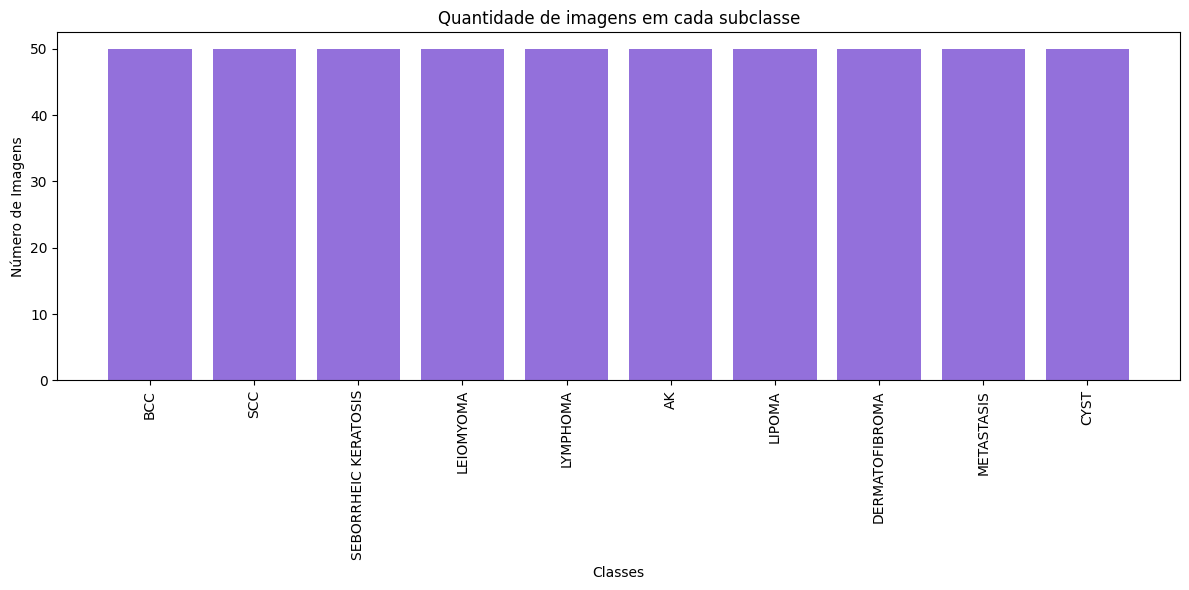

In [15]:
import os
import matplotlib.pyplot as plt

class_dir = '/content/CLASS/'

# Lista de subdiretórios (classes)
class_folders = [f for f in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, f))]

# Cria um dicionário para armazenar as contagens de imagens para cada classe
image_counts = {}
for folder in class_folders:
    image_counts[folder] = len(os.listdir(os.path.join(class_dir, folder)))

# Ordena as classes com base nas contagens de imagens (opcional)
sorted_classes = sorted(image_counts.items(), key=lambda item: item[1], reverse=True)

# Extrai nomes de classes e contagens de imagens para plotagem
classes = [item[0] for item in sorted_classes]
counts = [item[1] for item in sorted_classes]

plt.figure(figsize=(12, 6))
plt.bar(classes, counts)
plt.bar(classes, counts, color='mediumpurple')
plt.xlabel("Classes")
plt.ylabel("Número de Imagens")
plt.title("Quantidade de imagens em cada subclasse")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Separação para Treino, Teste e Validação

In [16]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Diretório base contendo as imagens organizadas em subpastas
base_dir = '/content/CLASS'

# Diretórios de saída para treino, teste e validação
output_dir = '/content/'
train_dir = os.path.join(output_dir, 'TRAIN')
test_dir = os.path.join(output_dir, 'TEST')
val_dir = os.path.join(output_dir, 'VAL')

# Criar os diretórios de saída
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Proporções para a divisão
test_size = 0.2  # 20% para teste
val_size = 0.2   # 20% do conjunto restante (após separar o teste)

# Dividir os dados para cada classe (subpasta)
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Obter todas as imagens da classe
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Dividir os dados em treino, teste e validação
    train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

    # Criar diretórios específicos para a classe
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Mover as imagens para os diretórios apropriados
    for image in train_images:
        shutil.copy(image, os.path.join(train_dir, class_name))
    for image in test_images:
        shutil.copy(image, os.path.join(test_dir, class_name))
    for image in val_images:
        shutil.copy(image, os.path.join(val_dir, class_name))

    print(f"Classe {class_name}:")
    print(f"  Treino: {len(train_images)} imagens")
    print(f"  Teste: {len(test_images)} imagens")
    print(f"  Validação: {len(val_images)} imagens")

print("\nDivisão concluída. Os dados foram separados em treino, teste e validação respeitando os labels.")

Classe BCC:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe SCC:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe SEBORRHEIC KERATOSIS:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe LEIOMYOMA:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe LYMPHOMA:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe AK:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe LIPOMA:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe DERMATOFIBROMA:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe METASTASIS:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens
Classe CYST:
  Treino: 32 imagens
  Teste: 10 imagens
  Validação: 8 imagens

Divisão concluída. Os dados foram separados em treino, teste e validação respeitando os labels.


In [17]:
image = []
dir = '/content/TEST/METASTASIS/'
for img in os.listdir(dir):
    image_path = os.path.join(dir, img)
    image.append(cv2.imread(image_path))
print(image[0].shape)

(364, 408, 3)


In [18]:
import os

base_dir = '/content/CLASS'

class_counts = {}

for subfolder in os.listdir(base_dir):
    subfolder_path = os.path.join(base_dir, subfolder)
    if os.path.isdir(subfolder_path):
        class_counts[subfolder] = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

sorted_classes = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)

top_10_classes = [item[0] for item in sorted_classes[:10]]

categories = top_10_classes

print(categories)

['BCC', 'SCC', 'SEBORRHEIC KERATOSIS', 'LEIOMYOMA', 'LYMPHOMA', 'AK', 'LIPOMA', 'DERMATOFIBROMA', 'METASTASIS', 'CYST']


In [19]:
train_dir = '/content/TRAIN/'
val_dir = '/content/VAL/'
test_dir = '/content/TEST/'

x_test = []
y_test = []
x_train = []
y_train = []
x_val = []
y_val = []

image_shape = (200,200,3)

for dir in os.listdir(train_dir):
    if dir in categories:
       path = os.path.join(train_dir, dir)
       for image in tqdm(os.listdir(path), desc=f'Processing {dir}'):
          image = cv2.imread(os.path.join(path, image))
          # Redimenciona a imagem para o formato que eu quero
          image = cv2.resize(image, (image_shape[0], image_shape[1]))
          x_train.append(image)
          y_train.append(categories.index(dir))

for dir in os.listdir(test_dir):
    if dir in categories:
       path = os.path.join(test_dir, dir)
       for image in tqdm(os.listdir(path), desc=f'Processing {dir}'):
          image = cv2.imread(os.path.join(path, image))
         # Redimenciona a imagem para o formato que eu quero
          image = cv2.resize(image, (image_shape[0], image_shape[1]))
          x_test.append(image)
          y_test.append(categories.index(dir))

for dir in os.listdir(val_dir):
    if dir in categories:
       path = os.path.join(val_dir, dir)
       for image in tqdm(os.listdir(path), desc=f'Processing {dir}'):
          image = cv2.imread(os.path.join(path, image))
          # Redimenciona a imagem para o formato que eu quero
          image = cv2.resize(image, (image_shape[0], image_shape[1]))
          x_val.append(image)
          y_val.append(categories.index(dir))

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

Processing CYST: 100%|██████████| 8/8 [00:00<00:00, 359.52it/s]


In [20]:
#Exibir formas dos arrays
print(f"x_train shape: {x_train.shape}, y_train shape: {np.array(y_train).shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {np.array(y_test).shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {np.array(y_val).shape}")

x_train shape: (320, 200, 200, 3), y_train shape: (320,)
x_test shape: (100, 200, 200, 3), y_test shape: (100,)
x_val shape: (80, 200, 200, 3), y_val shape: (80,)


In [21]:
#Normalização
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val = x_val / 255.0

# Pré treinamento - DenseNet

In [22]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#Carregar a DenseNet121 pré-treinada
base_model = DenseNet121(weights='imagenet',
                         include_top=False,
                         input_shape=(200, 200, 3))

#Congelar as camadas do modelo base
base_model.trainable = False

base_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 206, 206, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 100, 100, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 100, 100, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 100, 100, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 102, 102, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 50, 50, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 50, 50, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 50, 50, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 50, 50, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 50, 50, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 50, 50, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 50, 50, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [23]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    base_model, #Transfer Learning
    GlobalAveragePooling2D(), # Reduz a dimensionalidade
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)), # Camada intermediária com L2
    Dense(len(categories), activation='softmax', kernel_regularizer=l2(0.01)) # Camada de saída com L2
])

In [24]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 6, 6, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [25]:
import numpy as np

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)


history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.2721 - loss: 4.3590 - val_accuracy: 0.8250 - val_loss: 3.0506
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.7288 - loss: 2.9894 - val_accuracy: 0.8875 - val_loss: 2.2153
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.8014 - loss: 2.2564 - val_accuracy: 0.9125 - val_loss: 1.7855
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8556 - loss: 1.8334 - val_accuracy: 0.8875 - val_loss: 1.5690
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.8328 - loss: 1.6371 - val_accuracy: 0.9125 - val_loss: 1.4068
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.8687 - loss: 1.4149 - val_accuracy: 0.9125 - val_loss: 1.2797
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.8878 - loss: 1.2859 - val_accuracy: 0.9000 - val_loss: 1.2311
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.9405 - loss: 1.1009 - val_accuracy: 0.9125 - val_loss:

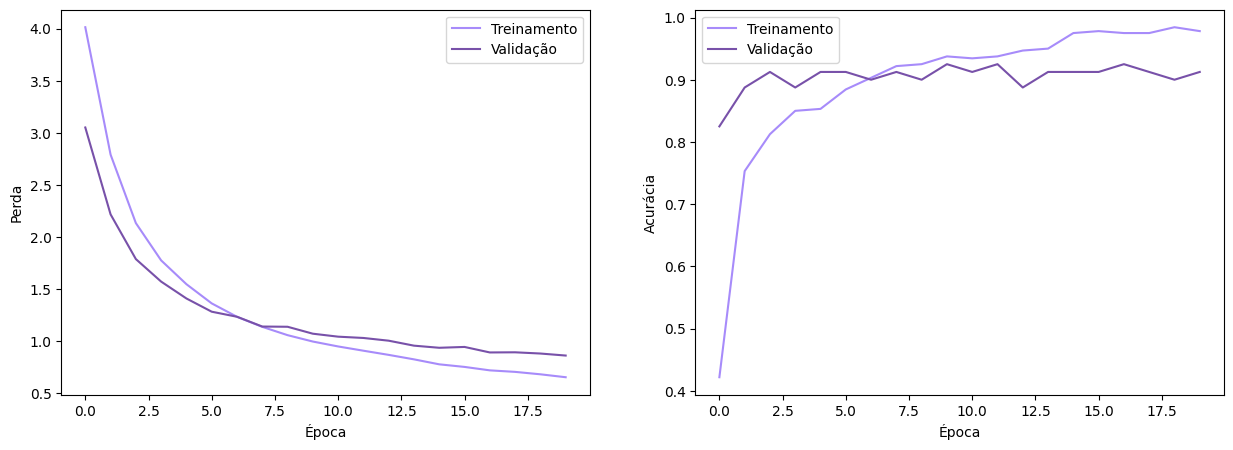

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Treinando e validando Valor Perda
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Treinamento", color="#A78BFA")
plt.plot(history.history["val_loss"], label="Validação", color="#7851a9")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()

# Treinando e validando Acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Treinamento", color="#A78BFA")
plt.plot(history.history["val_accuracy"], label="Validação", color="#7851a9")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


<Axes: title={'center': 'Matriz Confusão'}>

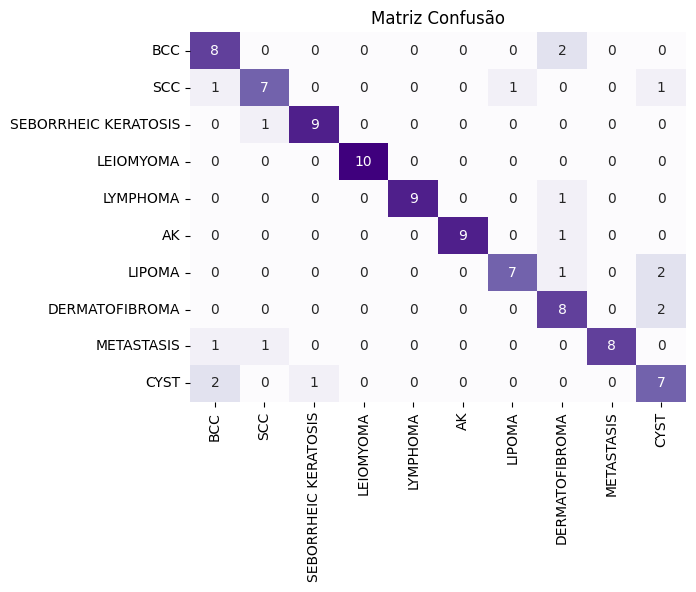

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

Y_pred_prob = model.predict(x_test)

Y_pred_test = np.argmax(Y_pred_prob, axis=1)

cmat = confusion_matrix(y_test, Y_pred_test)
cm_df = pd.DataFrame(cmat)

unique_classes = np.unique(np.concatenate((y_test, Y_pred_test)))
classes = [categories[i] for i in unique_classes]

plt.figure()
ax = plt.subplot()
plt.title("Matriz Confusão")
sns.heatmap(cm_df, annot=True, cmap="Purples", fmt="d", cbar=False, xticklabels=classes, yticklabels=classes)

In [28]:
import os
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def save_training_results(model, history, x_test, y_test, categories):
    """Salva os resultados do treinamento, incluindo gráficos, matriz de confusão (usando sns.heatmap) e modelo."""

    # Gera um nome de diretório exclusivo usando uuid
    unique_id = str(uuid.uuid4())[:8]  # Obtém os primeiros 8 caracteres para abreviar
    output_dir = os.path.join("/content", f"training_results_{unique_id}")
    os.makedirs(output_dir, exist_ok=True)  # Cria o diretório

    # Salva o modelo
    model_path = os.path.join(output_dir, "model.h5")
    model.save(model_path)
    print(f"Modelo salvo em: {model_path}")

    # Salva o gráfico de perda/acurácia de treinamento e validação
    plot_filename = os.path.join(output_dir, "training_plot.png")
    plt.figure(figsize=(15, 5))

    # Gráfico de perda de treinamento e validação
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Treinamento", color="#A78BFA")
    plt.plot(history.history["val_loss"], label="Validação", color="#7851a9")
    plt.xlabel("Época")
    plt.ylabel("Perda")
    plt.legend()

    # Gráfico de acurácia de treinamento e validação
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Treinamento", color="#A78BFA")
    plt.plot(history.history["val_accuracy"], label="Validação", color="#7851a9")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()

    # Salva o gráfico
    plt.savefig(plot_filename)
    plt.show()  # Exibe o gráfico
    print(f"Gráfico de treinamento salvo em: {plot_filename}")

    # Gera e salva a matriz de confusão usando sns.heatmap
    Y_pred_prob = model.predict(x_test)
    Y_pred_test = np.argmax(Y_pred_prob, axis=1)
    cmat = confusion_matrix(y_test, Y_pred_test)


    # Obtém classes únicas de previsões e valores reais
    unique_classes = np.unique(np.concatenate((y_test, Y_pred_test)))

    # Filtra categorias para incluir apenas aquelas presentes no conjunto de teste
    filtered_categories = [categories[i] for i in unique_classes]

    cm_df = pd.DataFrame(cmat, index=filtered_categories, columns=filtered_categories)
    plt.figure(figsize=(8, 8))
    # sns.heatmap(cm_df, annot=True, cmap="Purples", fmt="d", cbar=False, square=True)
    sns.heatmap(cm_df, annot=True, cmap="Purples", fmt="d", cbar=False, xticklabels=classes, yticklabels=classes)
    plt.title("Matriz de Confusão")
    plt.xlabel("Previsões")
    plt.ylabel("Valores Reais")

    cm_filename = os.path.join(output_dir, "confusion_matrix.png")
    plt.savefig(cm_filename)
    plt.show()
    print(f"Matriz de confusão salva em: {cm_filename}")

Modelo salvo em: /content/training_results_855e77e3/model.h5


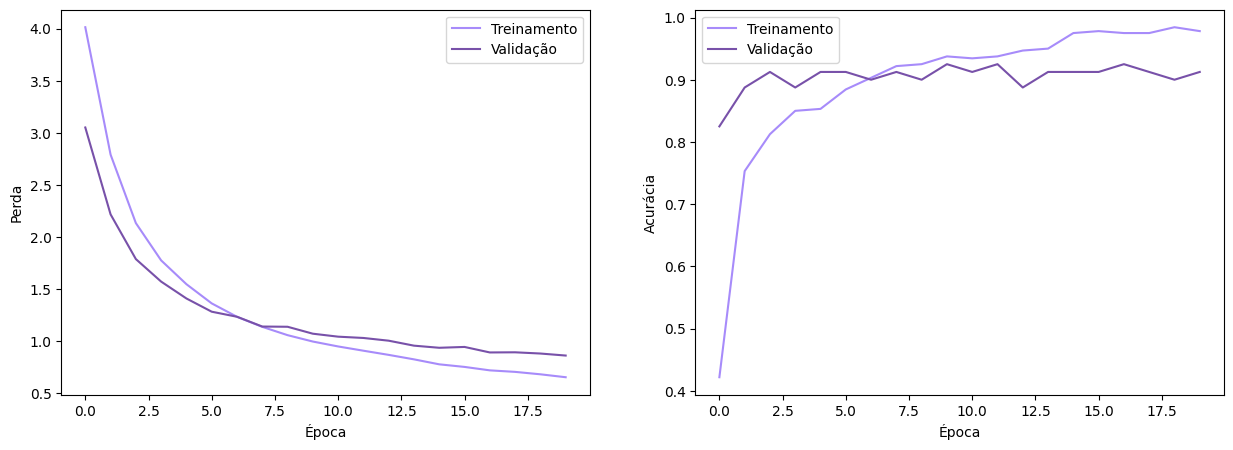

Gráfico de treinamento salvo em: /content/training_results_855e77e3/training_plot.png
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


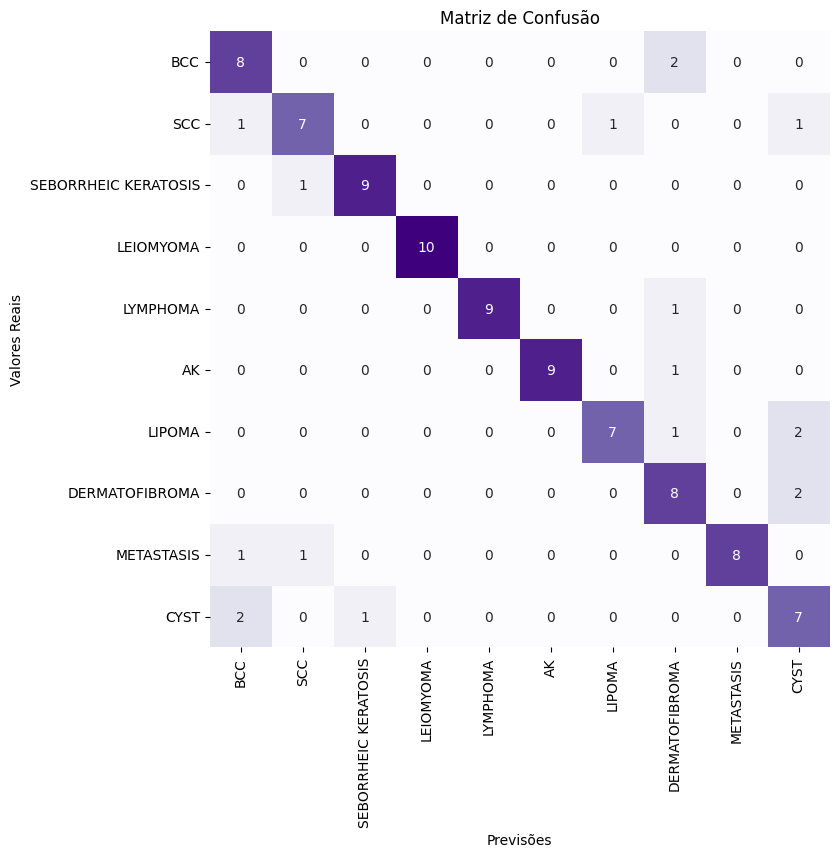

Matriz de confusão salva em: /content/training_results_855e77e3/confusion_matrix.png


In [29]:
save_training_results(model, history, x_test, y_test, categories)

Modelo salvo em: /content/training_results_24d1e2b6/model.h5


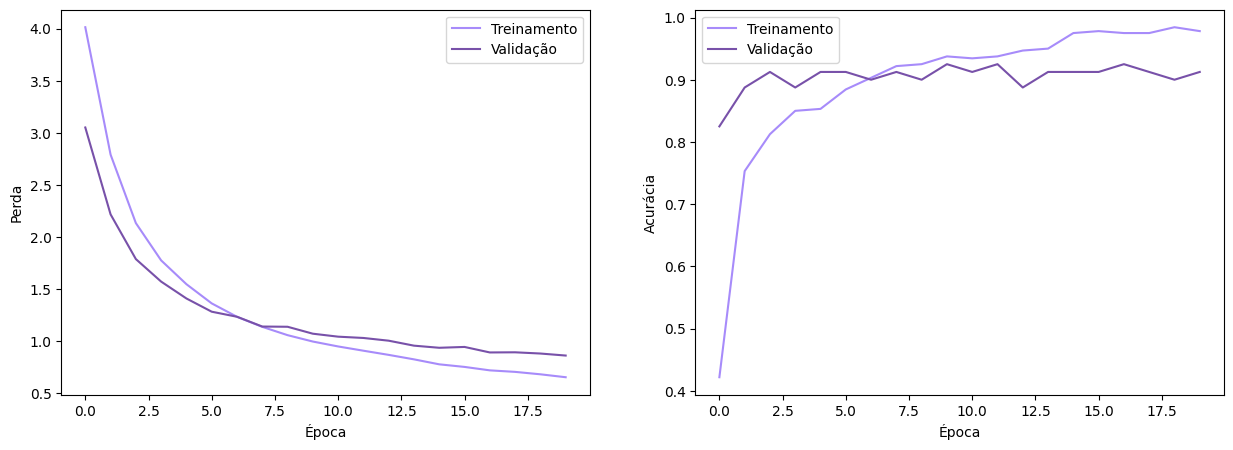

Gráfico de treinamento salvo em: /content/training_results_24d1e2b6/training_plot.png
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


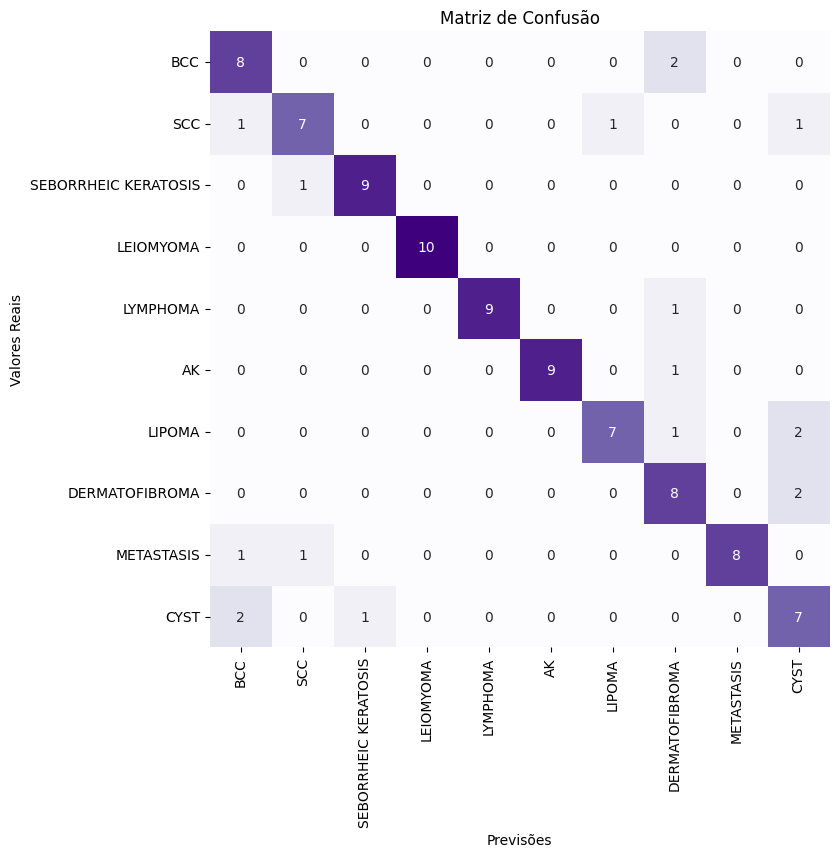

Matriz de confusão salva em: /content/training_results_24d1e2b6/confusion_matrix.png


In [30]:
save_training_results(model, history, x_test, y_test, categories)

Modelo salvo em: /content/training_results_66e3f5c6/model.h5


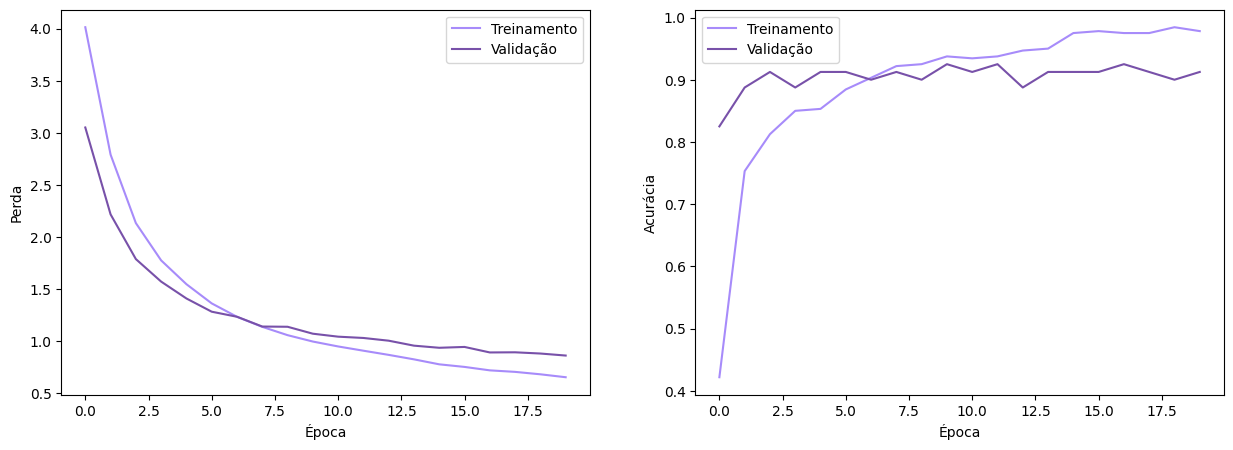

Gráfico de treinamento salvo em: /content/training_results_66e3f5c6/training_plot.png
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


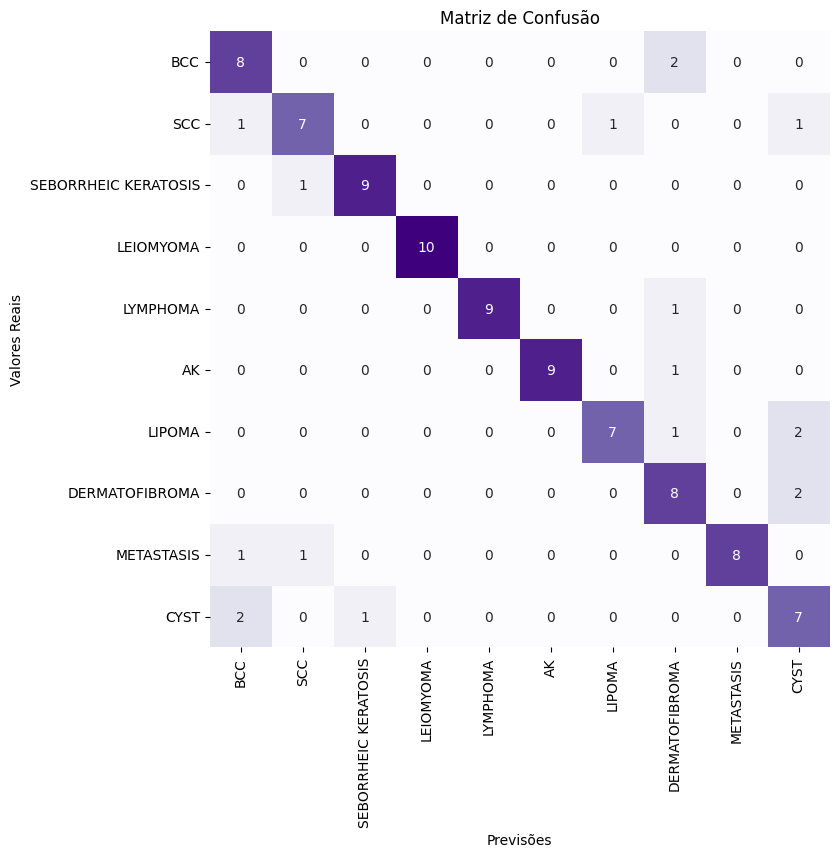

Matriz de confusão salva em: /content/training_results_66e3f5c6/confusion_matrix.png


In [31]:
save_training_results(model, history, x_test, y_test, categories)